In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from supportfunctions import PDESolver_2d, finiteDiff
from solver_2d import false_transient_one_iteration_python
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one, solve_smooth
from solver import pde_solve
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from multiprocessing import Pool
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["figure.edgecolor"] = "w"
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams["savefig.dpi"] = 300

# Simple version
$$
\begin{aligned}
0 = \max_{\mathcal{E}} & - \delta \phi(y) + \delta \eta log(\mathcal{E}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \theta \mathcal{E}) \\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$

$$
\mathcal{E}^* = -\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}
$$

$$
\begin{aligned}
0 = & - \delta \phi(y) + \delta \eta log(-\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 )  - \delta \eta\\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$


# Adding robustness and ambiguity:

Process:

$$
dY_t^1  = Y_t^2 dt
$$

$$
dY_t^2 =   - \lambda Y_t^2 dt + \lambda \theta \mathcal{E} dt
$$


HJB:

$$
\begin{aligned}
0 = \max_{\mathcal{E}} \min_{\omega_\ell } & - \delta \phi(y_1, y_2) + \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \sum_{\ell}^L 
\omega_\ell  \theta_\ell \mathcal{E}) \\ 
& + \frac{(\eta - 1)}{\delta} \left(\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\} \right) y_2 \\
& + \xi_a \sum_{\ell}^L \omega_\ell (\log \omega_\ell - \log \pi^a_i)
\end{aligned}
$$

$$
    \hat \pi^{a,*}_i \propto \pi_i^a \exp\left( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E} \right)
$$

and
$$
\mathcal{E}^* = - \frac{\eta}{\frac{\partial \phi }{\partial y_2} \lambda \sum_i \hat\pi^a_i\theta_i}
$$
Plug back in:

$$
\begin{aligned}
0 = \max_{\mathcal{E}}  & - \delta \phi(y) +  \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2) \\ 
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2 \\
& - \xi_a  \log \left(\sum_i\hat \pi^a_i \exp( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E}) \right)
\end{aligned}
$$

$$
\phi(\bar y_1, y_2) \approx  - \xi_p \log \left (\sum_m \pi_m^p \exp\left[-\frac{1}{\xi_p }\phi_m(\bar y_1, y_2) \right] \right) 
$$

In [2]:
# parameters
δ = 0.01
η = 0.032
ξa = 0.01
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
θ = np.mean(θ_list)
σy = 1.2*θ
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.linspace(0., 1./3, 20)
# y grid
# λ = np.log(2)/6
λ = 2

In [3]:
y1_step = .04
y1_grid = np.arange(0., 4., y1_step)

y2_step = .001
y2_grid = np.arange(0., .05, y2_step)

(y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
stateSpace = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])
hy1 = y1_grid[1] - y1_grid[0]
hy2 = y2_grid[1] - y2_grid[0]
n_y1 = len(y1_grid)
n_y2 = len(y2_grid)

In [4]:
tol = 1e-7
ϵ = .1
πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
πa = πa_o


def solve_prep(y1_mat, y2_mat, γ3, tol=1e-7, ϵ=1, max_iter=2000, fraction=0.05):
    πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
    θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
    for i in range(len(θ_list)):
        θ_mat[i] = θ_list[i]
    πa = πa_o
    dΛ1 = γ1 + γ2*y1_mat + γ3*(y1_mat - ȳ)*(y1_mat >ȳ)
    ems_new = η*np.ones(y1_mat.shape)
    ems_old = ems_new
    episode = 0
    lhs_error = 0.5
    while lhs_error > tol and episode  < max_iter:
        if episode ==0:
            v0 =  - η*((y1_mat+y2_mat) + (y1_mat+y2_mat)**2)
        else:
            vold = v0.copy()
        v0_dy1 = derivatives_2d(v0,0,1,hy1)
        v0_dy2 = derivatives_2d(v0,1,1,hy2)
        # updating controls
        ems_new =  - η/(v0_dy2*λ*np.sum(θ_mat*πa, axis=0))
        ems_new[ems_new <= 1e-15] = 1e-15
        ems = ems_new*fraction + ems_old*(1 - fraction)
        
        weight = np.array([-1/ξa*v0_dy2*λ*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πa = πa_o*np.exp(weight)
#         πa[πa<1e-15] = 1e-15
        πa = πa/np.sum(πa, axis=0)
        
#         print(np.min(ems))
        # HJB coefficient
        A =  -δ*np.ones(y1_mat.shape)
        B_y1 =  y2_mat
        B_y2 = λ*( - y2_mat + ems*np.sum(θ_mat*πa, axis=0))
        C_yy1 = np.zeros(y1_mat.shape)
        C_yy2 = np.zeros(y1_mat.shape)
        D = η*np.log(ems) +  (η-1)/δ*dΛ1*y2_mat + ξa*np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0) 
        # PDE solver
        solve_start = time.time()
        out = PDESolver_2d(stateSpace, A, B_y1, B_y2, C_yy1, C_yy2, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y1*v0_dy1 + B_y2*v0_dy2  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)/ϵ))
        #     if episode % 1 == 0:
#         print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems
#         print("End of PDE solver, takes time: {}".format(time.time() - solve_start))
    
    print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    result = dict(v0=v0, ems=ems, πa=πa)
    return result

In [5]:
def ode_y_parallel(args_list):
    with Pool() as p:
        res_list = p.starmap(solve_prep, args_list)
    return res_list        

def postjump_list(args_list):
    res_list = ode_y_parallel(args_list)
    ϕ_list = np.zeros((len(γ3_list), len(y1_grid), len(y2_grid)))
    ems_list = np.zeros((len(γ3_list), len(y1_grid), len(y2_grid)))
    for j in range(len(γ3_list)):
        ϕ_list[j] = res_list[j]['v0']
        ems_list[j] = res_list[j]['ems']
        
    return ϕ_list, ems_list

args_list_test  = []
for γ3_i in γ3_list:
    args_iter = (y1_mat, y2_mat, γ3_i, 1e-6, 1., 1000, 0.05)
    args_list_test.append(args_iter)
ϕ_list, ems_list = postjump_list(args_list_test)

Episode 1000: PDE Error: 0.000289411670; False Transient Error: 0.000001161700; Iterations: 584; CG Error: 0.000000000098
Episode 957: PDE Error: 0.002042111889; False Transient Error: 0.000000995661; Iterations: 697; CG Error: 0.000000000098
Episode 1000: PDE Error: 0.016472298678; False Transient Error: 0.000002347391; Iterations: 778; CG Error: 0.000000000099
Episode 1000: PDE Error: 0.006265141508; False Transient Error: 0.000001631688; Iterations: 781; CG Error: 0.000000000099
Episode 1000: PDE Error: 0.032310887478; False Transient Error: 0.000002476669; Iterations: 758; CG Error: 0.000000000096
Episode 1000: PDE Error: 0.038141265845; False Transient Error: 0.000002397040; Iterations: 747; CG Error: 0.000000000096
Episode 1000: PDE Error: 0.028391879423; False Transient Error: 0.000002499763; Iterations: 775; CG Error: 0.000000000098
Episode 1000: PDE Error: 0.024443394645; False Transient Error: 0.000002491579; Iterations: 783; CG Error: 0.000000000099
Episode 1000: PDE Error: 

In [6]:
np.save("v_list_2", ϕ_list)
np.save("e_list_2", ems_list)

In [5]:
ϕ_list = np.load("v_list_2.npy")
ems_list = np.load("e_list_2.npy")

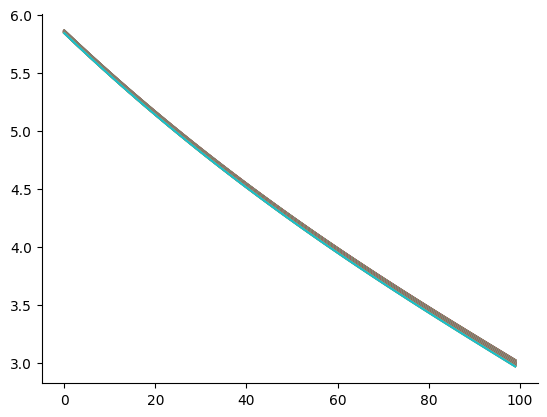

In [8]:
loc_start = np.abs(y2_grid - np.mean(θ_list)).argmin()
loc_twi = np.abs(y2_grid - 2 * np.mean(θ_list)).argmin()
loc_tri = np.abs(y2_grid - 3 * np.mean(θ_list)).argmin()
plt.plot(ϕ_list[0])
plt.show()

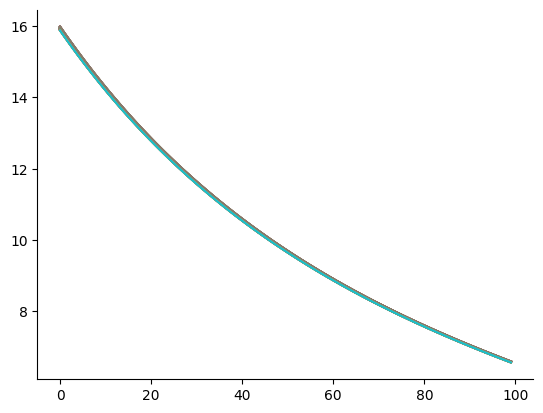

In [9]:
plt.plot(ems_list[0])
# plt.ylim(-6,6)
plt.show()

In [41]:
y1_grid_cap = np.arange(0., 2.1 + y1_step, y1_step)
loc_2 = np.abs(y1_grid - 2.).argmin()
ξp = 1
ϵ = 0.01
max_iter = 2000
dmg_weight = np.ones(len(γ3_list)) / len(γ3_list)
ϕ_weight = np.average(np.exp(-1 / ξp * ϕ_list), axis=0, weights=dmg_weight)

ϕ_equiv = -ξp * np.log(ϕ_weight)

(y1_mat_cap, y2_mat_cap) = np.meshgrid(y1_grid_cap, y2_grid, indexing='ij')
dy1 = y1_grid_cap[1] - y1_grid[0]
dy2 = y2_grid[1] - y2_grid[0]
num_y1 = len(y1_grid_cap)
num_y2 = len(y2_grid)
πd_o = np.ones((len(γ3_list), num_y1, num_y2)) / len(γ3_list)
πa_o = np.ones((len(θ_list), num_y1, num_y2)) / len(θ_list)
θ_mat = np.zeros((len(θ_list), num_y1, num_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
dΛ1 = γ1 + γ2 * y1_mat_cap

r1 = 1.5
r2 = 2.5
y_lower = 1.5
Intensity = r1 * (np.exp(r2 / 2 * (y1_mat_cap - y_lower)**2) -
                  1) * (y1_mat_cap >= y_lower)

# initiate v and control
tol = 1e-6
ems = η
# ems_old = ems
ems_old = ems_guess
lhs_error = 1
episode = 0
# v0 = ϕ_equiv[:num_y1]
v0 = v_guess
v_m = np.zeros(πd_o.shape)
for i in range(len(γ3_list)):
    v_m[i] = ϕ_list[i][loc_2]

while lhs_error > tol and episode < max_iter:
    v0_old = v0.copy()
    v0_dy1 = derivatives_2d(v0, 0, 1, hy1)
    v0_dy2 = derivatives_2d(v0, 1, 1, hy2)
    # updating controls
    weight = np.array([-1 / ξa * v0_dy2 * λ * ems_old * θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o * np.exp(weight)
    πa[πa < 1e-15] = 1e-15
    πa = πa / np.sum(πa, axis=0)
    ems_new = -η / (v0_dy2 * λ * np.sum(θ_mat * πa, axis=0))
    ems_new[ems_new <= 1e-15] = 1e-15
    ems = ems_new * 0.05 + ems_old * 0.95
    #     print(np.min(ems))
    g_m = np.exp(1 / ξp * (v0 - v_m))
    # HJB coefficient
    A = -δ * np.ones(y1_mat_cap.shape) - Intensity * np.sum(πd_o * g_m, axis=0)
    B_y1 = y2_mat_cap
    B_y2 = λ * (-y2_mat_cap + ems * np.sum(θ_mat * πa, axis=0))
    C_yy1 = np.zeros(y1_mat_cap.shape)
    C_yy2 = np.zeros(y1_mat_cap.shape)
    D = η * np.log(ems) + (η - 1) / δ * dΛ1 * y2_mat_cap + ξa * np.sum(
        πa * (np.log(πa) - np.log(πa_o)), axis=0) + Intensity * np.sum(
            πd_o * g_m * v_m, axis=0) + ξp * Intensity * np.sum(
                πd_o * (1 - g_m + g_m * np.log(g_m)), axis=0)
    phi_mat = false_transient_one_iteration_python(
        A,
        B_y1,
        B_y2,
        C_yy1,
        C_yy2,
        D,
        v0,
        ϵ,
        hy1,
        hy2,
        bc=(np.zeros(num_y2), ϕ_equiv[num_y1 - 1], np.zeros(num_y1),
            np.zeros(num_y1)),
        impose_bc=(False, False, False, False))

    rhs = A * phi_mat + B_y1 * v0_dy1 + B_y2 * v0_dy2 + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((phi_mat - v0_old) / ϵ))
    v0 = phi_mat
    ems_old = ems
    episode += 1
    print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}'.format(episode, lhs_error, rhs_error))

Episode: 1	 lhs error: 0.000329705717	 rhs error: 0.033250256639
Episode: 2	 lhs error: 0.000329663814	 rhs error: 0.033250257477
Episode: 3	 lhs error: 0.000329621866	 rhs error: 0.033250258316
Episode: 4	 lhs error: 0.000329579870	 rhs error: 0.033250259156
Episode: 5	 lhs error: 0.000329537829	 rhs error: 0.033250259998
Episode: 6	 lhs error: 0.000329495741	 rhs error: 0.033250260841
Episode: 7	 lhs error: 0.000329453607	 rhs error: 0.033250261684
Episode: 8	 lhs error: 0.000329411427	 rhs error: 0.033250262529
Episode: 9	 lhs error: 0.000329369201	 rhs error: 0.033250263375
Episode: 10	 lhs error: 0.000329326930	 rhs error: 0.033250264223
Episode: 11	 lhs error: 0.000329284610	 rhs error: 0.033250265071
Episode: 12	 lhs error: 0.000329242246	 rhs error: 0.033250265920
Episode: 13	 lhs error: 0.000329199836	 rhs error: 0.033250266771
Episode: 14	 lhs error: 0.000329157379	 rhs error: 0.033250267623
Episode: 15	 lhs error: 0.000329114876	 rhs error: 0.033250268476
Episode: 16	 lhs er

Episode: 127	 lhs error: 0.000324065657	 rhs error: 0.033250370393
Episode: 128	 lhs error: 0.000324018022	 rhs error: 0.033250371354
Episode: 129	 lhs error: 0.000323970342	 rhs error: 0.033250372316
Episode: 130	 lhs error: 0.000323922618	 rhs error: 0.033250373278
Episode: 131	 lhs error: 0.000323874849	 rhs error: 0.033250374242
Episode: 132	 lhs error: 0.000323827036	 rhs error: 0.033250375206
Episode: 133	 lhs error: 0.000323779177	 rhs error: 0.033250376171
Episode: 134	 lhs error: 0.000323731275	 rhs error: 0.033250377137
Episode: 135	 lhs error: 0.000323683327	 rhs error: 0.033250378104
Episode: 136	 lhs error: 0.000323635336	 rhs error: 0.033250379071
Episode: 137	 lhs error: 0.000323587299	 rhs error: 0.033250380039
Episode: 138	 lhs error: 0.000323539218	 rhs error: 0.033250381008
Episode: 139	 lhs error: 0.000323491093	 rhs error: 0.033250381978
Episode: 140	 lhs error: 0.000323442923	 rhs error: 0.033250382949
Episode: 141	 lhs error: 0.000323394709	 rhs error: 0.03325038

Episode: 250	 lhs error: 0.000319181549	 rhs error: 0.033250493880
Episode: 251	 lhs error: 0.000319144982	 rhs error: 0.033250494921
Episode: 252	 lhs error: 0.000319108372	 rhs error: 0.033250495963
Episode: 253	 lhs error: 0.000319071717	 rhs error: 0.033250497006
Episode: 254	 lhs error: 0.000319035019	 rhs error: 0.033250498049
Episode: 255	 lhs error: 0.000318998277	 rhs error: 0.033250499093
Episode: 256	 lhs error: 0.000318961493	 rhs error: 0.033250500137
Episode: 257	 lhs error: 0.000318924664	 rhs error: 0.033250501181
Episode: 258	 lhs error: 0.000318887792	 rhs error: 0.033250502226
Episode: 259	 lhs error: 0.000318850875	 rhs error: 0.033250503272
Episode: 260	 lhs error: 0.000318813916	 rhs error: 0.033250504318
Episode: 261	 lhs error: 0.000318776913	 rhs error: 0.033250505365
Episode: 262	 lhs error: 0.000318739867	 rhs error: 0.033250506412
Episode: 263	 lhs error: 0.000318702777	 rhs error: 0.033250507459
Episode: 264	 lhs error: 0.000318665643	 rhs error: 0.03325050

Episode: 376	 lhs error: 0.000314233311	 rhs error: 0.033250628479
Episode: 377	 lhs error: 0.000314191316	 rhs error: 0.033250629569
Episode: 378	 lhs error: 0.000314149279	 rhs error: 0.033250630660
Episode: 379	 lhs error: 0.000314107198	 rhs error: 0.033250631750
Episode: 380	 lhs error: 0.000314065077	 rhs error: 0.033250632841
Episode: 381	 lhs error: 0.000314022912	 rhs error: 0.033250633932
Episode: 382	 lhs error: 0.000313980705	 rhs error: 0.033250635024
Episode: 383	 lhs error: 0.000313938455	 rhs error: 0.033250636115
Episode: 384	 lhs error: 0.000313896164	 rhs error: 0.033250637207
Episode: 385	 lhs error: 0.000313853829	 rhs error: 0.033250638300
Episode: 386	 lhs error: 0.000313811453	 rhs error: 0.033250639392
Episode: 387	 lhs error: 0.000313769033	 rhs error: 0.033250640485
Episode: 388	 lhs error: 0.000313726572	 rhs error: 0.033250641578
Episode: 389	 lhs error: 0.000313684069	 rhs error: 0.033250642671
Episode: 390	 lhs error: 0.000313641523	 rhs error: 0.03325064

Episode: 500	 lhs error: 0.000308894219	 rhs error: 0.033250765143
Episode: 501	 lhs error: 0.000308862039	 rhs error: 0.033250766253
Episode: 502	 lhs error: 0.000308829817	 rhs error: 0.033250767363
Episode: 503	 lhs error: 0.000308797554	 rhs error: 0.033250768474
Episode: 504	 lhs error: 0.000308765250	 rhs error: 0.033250769584
Episode: 505	 lhs error: 0.000308732905	 rhs error: 0.033250770694
Episode: 506	 lhs error: 0.000308700519	 rhs error: 0.033250771805
Episode: 507	 lhs error: 0.000308668092	 rhs error: 0.033250772915
Episode: 508	 lhs error: 0.000308635623	 rhs error: 0.033250774026
Episode: 509	 lhs error: 0.000308603113	 rhs error: 0.033250775136
Episode: 510	 lhs error: 0.000308570563	 rhs error: 0.033250776247
Episode: 511	 lhs error: 0.000308537971	 rhs error: 0.033250777358
Episode: 512	 lhs error: 0.000308505338	 rhs error: 0.033250778469
Episode: 513	 lhs error: 0.000308472664	 rhs error: 0.033250779579
Episode: 514	 lhs error: 0.000308439949	 rhs error: 0.03325078

Episode: 624	 lhs error: 0.000304591854	 rhs error: 0.033250902836
Episode: 625	 lhs error: 0.000304554618	 rhs error: 0.033250903943
Episode: 626	 lhs error: 0.000304517343	 rhs error: 0.033250905051
Episode: 627	 lhs error: 0.000304480027	 rhs error: 0.033250906158
Episode: 628	 lhs error: 0.000304442671	 rhs error: 0.033250907265
Episode: 629	 lhs error: 0.000304405274	 rhs error: 0.033250908371
Episode: 630	 lhs error: 0.000304367837	 rhs error: 0.033250909478
Episode: 631	 lhs error: 0.000304330360	 rhs error: 0.033250910585
Episode: 632	 lhs error: 0.000304292842	 rhs error: 0.033250911691
Episode: 633	 lhs error: 0.000304255284	 rhs error: 0.033250912797
Episode: 634	 lhs error: 0.000304217687	 rhs error: 0.033250913904
Episode: 635	 lhs error: 0.000304180048	 rhs error: 0.033250915010
Episode: 636	 lhs error: 0.000304142370	 rhs error: 0.033250916116
Episode: 637	 lhs error: 0.000304104652	 rhs error: 0.033250917222
Episode: 638	 lhs error: 0.000304066893	 rhs error: 0.03325091

Episode: 750	 lhs error: 0.000299585930	 rhs error: 0.033251041141
Episode: 751	 lhs error: 0.000299543694	 rhs error: 0.033251042226
Episode: 752	 lhs error: 0.000299501419	 rhs error: 0.033251043310
Episode: 753	 lhs error: 0.000299459105	 rhs error: 0.033251044395
Episode: 754	 lhs error: 0.000299416752	 rhs error: 0.033251045479
Episode: 755	 lhs error: 0.000299374360	 rhs error: 0.033251046563
Episode: 756	 lhs error: 0.000299331930	 rhs error: 0.033251047646
Episode: 757	 lhs error: 0.000299289460	 rhs error: 0.033251048730
Episode: 758	 lhs error: 0.000299246951	 rhs error: 0.033251049813
Episode: 759	 lhs error: 0.000299204404	 rhs error: 0.033251050896
Episode: 760	 lhs error: 0.000299161817	 rhs error: 0.033251051979
Episode: 761	 lhs error: 0.000299119192	 rhs error: 0.033251053061
Episode: 762	 lhs error: 0.000299076528	 rhs error: 0.033251054143
Episode: 763	 lhs error: 0.000299033825	 rhs error: 0.033251055225
Episode: 764	 lhs error: 0.000298991083	 rhs error: 0.03325105

Episode: 874	 lhs error: 0.000295119287	 rhs error: 0.033251173493
Episode: 875	 lhs error: 0.000295085967	 rhs error: 0.033251174541
Episode: 876	 lhs error: 0.000295052608	 rhs error: 0.033251175587
Episode: 877	 lhs error: 0.000295019212	 rhs error: 0.033251176634
Episode: 878	 lhs error: 0.000294985777	 rhs error: 0.033251177680
Episode: 879	 lhs error: 0.000294952303	 rhs error: 0.033251178725
Episode: 880	 lhs error: 0.000294918792	 rhs error: 0.033251179771
Episode: 881	 lhs error: 0.000294885243	 rhs error: 0.033251180816
Episode: 882	 lhs error: 0.000294851655	 rhs error: 0.033251181860
Episode: 883	 lhs error: 0.000294818029	 rhs error: 0.033251182904
Episode: 884	 lhs error: 0.000294784365	 rhs error: 0.033251183948
Episode: 885	 lhs error: 0.000294750663	 rhs error: 0.033251184992
Episode: 886	 lhs error: 0.000294716922	 rhs error: 0.033251186035
Episode: 887	 lhs error: 0.000294683143	 rhs error: 0.033251187078
Episode: 888	 lhs error: 0.000294649327	 rhs error: 0.03325118

Episode: 999	 lhs error: 0.000290660383	 rhs error: 0.033251301325
Episode: 1000	 lhs error: 0.000290622344	 rhs error: 0.033251302321
Episode: 1001	 lhs error: 0.000290584269	 rhs error: 0.033251303317
Episode: 1002	 lhs error: 0.000290546156	 rhs error: 0.033251304311
Episode: 1003	 lhs error: 0.000290508006	 rhs error: 0.033251305306
Episode: 1004	 lhs error: 0.000290469819	 rhs error: 0.033251306300
Episode: 1005	 lhs error: 0.000290431595	 rhs error: 0.033251307293
Episode: 1006	 lhs error: 0.000290393334	 rhs error: 0.033251308286
Episode: 1007	 lhs error: 0.000290355036	 rhs error: 0.033251309279
Episode: 1008	 lhs error: 0.000290316700	 rhs error: 0.033251310271
Episode: 1009	 lhs error: 0.000290278327	 rhs error: 0.033251311262
Episode: 1010	 lhs error: 0.000290239918	 rhs error: 0.033251312254
Episode: 1011	 lhs error: 0.000290201471	 rhs error: 0.033251313244
Episode: 1012	 lhs error: 0.000290162987	 rhs error: 0.033251314234
Episode: 1013	 lhs error: 0.000290124466	 rhs err

Episode: 1122	 lhs error: 0.000286020610	 rhs error: 0.033251420150
Episode: 1123	 lhs error: 0.000285990630	 rhs error: 0.033251421084
Episode: 1124	 lhs error: 0.000285960613	 rhs error: 0.033251422018
Episode: 1125	 lhs error: 0.000285930560	 rhs error: 0.033251422951
Episode: 1126	 lhs error: 0.000285900471	 rhs error: 0.033251423883
Episode: 1127	 lhs error: 0.000285870345	 rhs error: 0.033251424815
Episode: 1128	 lhs error: 0.000285840183	 rhs error: 0.033251425746
Episode: 1129	 lhs error: 0.000285809985	 rhs error: 0.033251426676
Episode: 1130	 lhs error: 0.000285779750	 rhs error: 0.033251427606
Episode: 1131	 lhs error: 0.000285749479	 rhs error: 0.033251428536
Episode: 1132	 lhs error: 0.000285719172	 rhs error: 0.033251429465
Episode: 1133	 lhs error: 0.000285688829	 rhs error: 0.033251430393
Episode: 1134	 lhs error: 0.000285658449	 rhs error: 0.033251431321
Episode: 1135	 lhs error: 0.000285628033	 rhs error: 0.033251432248
Episode: 1136	 lhs error: 0.000285597581	 rhs er

Episode: 1245	 lhs error: 0.000282062474	 rhs error: 0.033251530791
Episode: 1246	 lhs error: 0.000282028075	 rhs error: 0.033251531654
Episode: 1247	 lhs error: 0.000281993641	 rhs error: 0.033251532518
Episode: 1248	 lhs error: 0.000281959172	 rhs error: 0.033251533380
Episode: 1249	 lhs error: 0.000281924667	 rhs error: 0.033251534242
Episode: 1250	 lhs error: 0.000281890127	 rhs error: 0.033251535104
Episode: 1251	 lhs error: 0.000281855551	 rhs error: 0.033251535965
Episode: 1252	 lhs error: 0.000281820940	 rhs error: 0.033251536825
Episode: 1253	 lhs error: 0.000281786293	 rhs error: 0.033251537685
Episode: 1254	 lhs error: 0.000281751611	 rhs error: 0.033251538544
Episode: 1255	 lhs error: 0.000281716894	 rhs error: 0.033251539403
Episode: 1256	 lhs error: 0.000281682141	 rhs error: 0.033251540261
Episode: 1257	 lhs error: 0.000281647353	 rhs error: 0.033251541118
Episode: 1258	 lhs error: 0.000281612529	 rhs error: 0.033251541975
Episode: 1259	 lhs error: 0.000281577670	 rhs er

Episode: 1368	 lhs error: 0.000277567985	 rhs error: 0.033251632532
Episode: 1369	 lhs error: 0.000277529292	 rhs error: 0.033251633320
Episode: 1370	 lhs error: 0.000277490564	 rhs error: 0.033251634108
Episode: 1371	 lhs error: 0.000277451801	 rhs error: 0.033251634895
Episode: 1372	 lhs error: 0.000277413005	 rhs error: 0.033251635681
Episode: 1373	 lhs error: 0.000277374174	 rhs error: 0.033251636467
Episode: 1374	 lhs error: 0.000277335308	 rhs error: 0.033251637252
Episode: 1375	 lhs error: 0.000277296409	 rhs error: 0.033251638036
Episode: 1376	 lhs error: 0.000277257476	 rhs error: 0.033251638820
Episode: 1377	 lhs error: 0.000277218508	 rhs error: 0.033251639603
Episode: 1378	 lhs error: 0.000277179506	 rhs error: 0.033251640386
Episode: 1379	 lhs error: 0.000277140469	 rhs error: 0.033251641167
Episode: 1380	 lhs error: 0.000277101399	 rhs error: 0.033251641948
Episode: 1381	 lhs error: 0.000277062294	 rhs error: 0.033251642729
Episode: 1382	 lhs error: 0.000277023155	 rhs er

Episode: 1490	 lhs error: 0.000273751602	 rhs error: 0.033251723731
Episode: 1491	 lhs error: 0.000273720300	 rhs error: 0.033251724436
Episode: 1492	 lhs error: 0.000273688965	 rhs error: 0.033251725140
Episode: 1493	 lhs error: 0.000273657596	 rhs error: 0.033251725844
Episode: 1494	 lhs error: 0.000273626192	 rhs error: 0.033251726546
Episode: 1495	 lhs error: 0.000273594755	 rhs error: 0.033251727248
Episode: 1496	 lhs error: 0.000273563285	 rhs error: 0.033251727950
Episode: 1497	 lhs error: 0.000273531780	 rhs error: 0.033251728650
Episode: 1498	 lhs error: 0.000273500242	 rhs error: 0.033251729350
Episode: 1499	 lhs error: 0.000273468670	 rhs error: 0.033251730049
Episode: 1500	 lhs error: 0.000273437064	 rhs error: 0.033251730748
Episode: 1501	 lhs error: 0.000273405424	 rhs error: 0.033251731446
Episode: 1502	 lhs error: 0.000273373751	 rhs error: 0.033251732143
Episode: 1503	 lhs error: 0.000273342043	 rhs error: 0.033251732839
Episode: 1504	 lhs error: 0.000273310303	 rhs er

Episode: 1611	 lhs error: 0.000269720538	 rhs error: 0.033251803744
Episode: 1612	 lhs error: 0.000269685196	 rhs error: 0.033251804360
Episode: 1613	 lhs error: 0.000269649822	 rhs error: 0.033251804975
Episode: 1614	 lhs error: 0.000269614414	 rhs error: 0.033251805590
Episode: 1615	 lhs error: 0.000269578974	 rhs error: 0.033251806203
Episode: 1616	 lhs error: 0.000269543501	 rhs error: 0.033251806816
Episode: 1617	 lhs error: 0.000269507995	 rhs error: 0.033251807429
Episode: 1618	 lhs error: 0.000269472457	 rhs error: 0.033251808040
Episode: 1619	 lhs error: 0.000269436885	 rhs error: 0.033251808651
Episode: 1620	 lhs error: 0.000269401281	 rhs error: 0.033251809261
Episode: 1621	 lhs error: 0.000269365643	 rhs error: 0.033251809870
Episode: 1622	 lhs error: 0.000269329973	 rhs error: 0.033251810478
Episode: 1623	 lhs error: 0.000269294271	 rhs error: 0.033251811086
Episode: 1624	 lhs error: 0.000269258535	 rhs error: 0.033251811692
Episode: 1625	 lhs error: 0.000269222767	 rhs er

Episode: 1734	 lhs error: 0.000265750566	 rhs error: 0.033251873718
Episode: 1735	 lhs error: 0.000265721905	 rhs error: 0.033251874239
Episode: 1736	 lhs error: 0.000265693211	 rhs error: 0.033251874758
Episode: 1737	 lhs error: 0.000265664486	 rhs error: 0.033251875277
Episode: 1738	 lhs error: 0.000265635727	 rhs error: 0.033251875794
Episode: 1739	 lhs error: 0.000265606937	 rhs error: 0.033251876311
Episode: 1740	 lhs error: 0.000265578115	 rhs error: 0.033251876828
Episode: 1741	 lhs error: 0.000265549260	 rhs error: 0.033251877343
Episode: 1742	 lhs error: 0.000265520373	 rhs error: 0.033251877858
Episode: 1743	 lhs error: 0.000265491453	 rhs error: 0.033251878371
Episode: 1744	 lhs error: 0.000265462502	 rhs error: 0.033251878884
Episode: 1745	 lhs error: 0.000265433518	 rhs error: 0.033251879397
Episode: 1746	 lhs error: 0.000265404502	 rhs error: 0.033251879908
Episode: 1747	 lhs error: 0.000265375453	 rhs error: 0.033251880419
Episode: 1748	 lhs error: 0.000265346372	 rhs er

Episode: 1857	 lhs error: 0.000261984736	 rhs error: 0.033251931614
Episode: 1858	 lhs error: 0.000261952149	 rhs error: 0.033251932034
Episode: 1859	 lhs error: 0.000261919531	 rhs error: 0.033251932453
Episode: 1860	 lhs error: 0.000261886881	 rhs error: 0.033251932871
Episode: 1861	 lhs error: 0.000261854200	 rhs error: 0.033251933288
Episode: 1862	 lhs error: 0.000261821488	 rhs error: 0.033251933704
Episode: 1863	 lhs error: 0.000261788744	 rhs error: 0.033251934119
Episode: 1864	 lhs error: 0.000261755969	 rhs error: 0.033251934534
Episode: 1865	 lhs error: 0.000261723162	 rhs error: 0.033251934948
Episode: 1866	 lhs error: 0.000261690324	 rhs error: 0.033251935361
Episode: 1867	 lhs error: 0.000261657454	 rhs error: 0.033251935773
Episode: 1868	 lhs error: 0.000261624553	 rhs error: 0.033251936184
Episode: 1869	 lhs error: 0.000261591621	 rhs error: 0.033251936594
Episode: 1870	 lhs error: 0.000261558657	 rhs error: 0.033251937004
Episode: 1871	 lhs error: 0.000261525662	 rhs er

Episode: 1980	 lhs error: 0.000257995498	 rhs error: 0.033251976869
Episode: 1981	 lhs error: 0.000257968988	 rhs error: 0.033251977183
Episode: 1982	 lhs error: 0.000257942447	 rhs error: 0.033251977497
Episode: 1983	 lhs error: 0.000257915874	 rhs error: 0.033251977810
Episode: 1984	 lhs error: 0.000257889272	 rhs error: 0.033251978122
Episode: 1985	 lhs error: 0.000257862638	 rhs error: 0.033251978433
Episode: 1986	 lhs error: 0.000257835973	 rhs error: 0.033251978744
Episode: 1987	 lhs error: 0.000257809278	 rhs error: 0.033251979053
Episode: 1988	 lhs error: 0.000257782551	 rhs error: 0.033251979362
Episode: 1989	 lhs error: 0.000257755794	 rhs error: 0.033251979669
Episode: 1990	 lhs error: 0.000257729006	 rhs error: 0.033251979976
Episode: 1991	 lhs error: 0.000257702188	 rhs error: 0.033251980282
Episode: 1992	 lhs error: 0.000257675338	 rhs error: 0.033251980587
Episode: 1993	 lhs error: 0.000257648458	 rhs error: 0.033251980891
Episode: 1994	 lhs error: 0.000257621547	 rhs er

In [40]:
v_guess = v0
ems_guess = ems

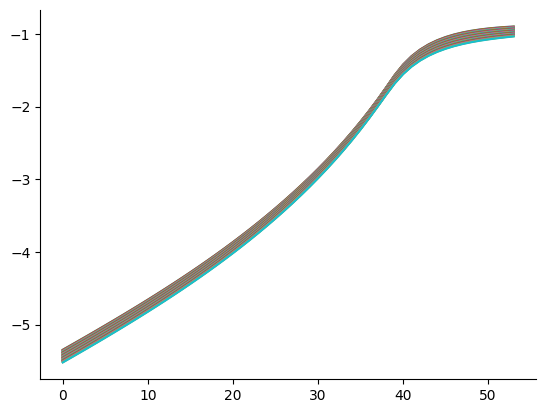

In [11]:
plt.plot((v_m  - v0)[-1])
plt.show()

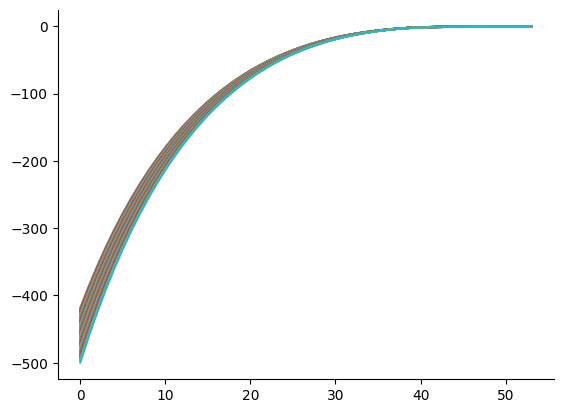

In [12]:
distort_inten =  np.sum(πd_o * g_m * (v_m - v0), axis=0)
# np.save(f"inten_multi_{λ}", distort_inten)
plt.plot(distort_inten)
plt.show()

In [13]:
np.save(f"ems_{λ}", ems)
np.save(f"v_{λ}", v0)

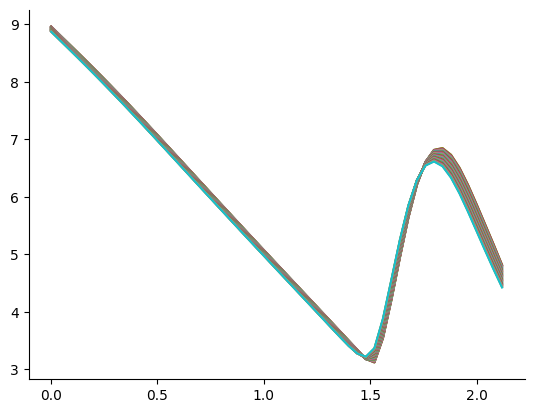

In [14]:
plt.plot(y1_grid_cap, ems)
plt.show()

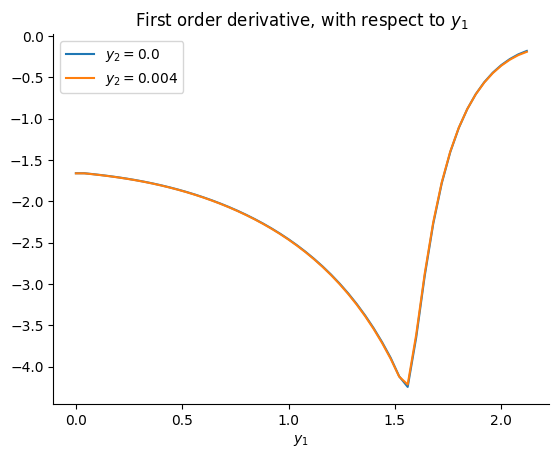

In [15]:
plt.title("First order derivative, with respect to $y_1$")
plt.plot(y1_grid_cap, v0_dy1[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy1[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy1")
plt.show()

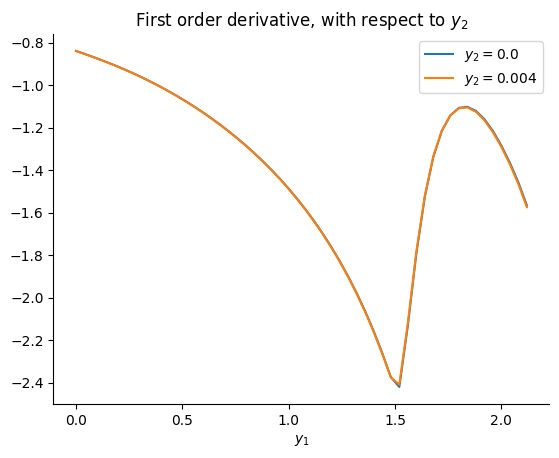

In [16]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y1_grid_cap, v0_dy2[:,0], label=r"$y_2 = {}$".format(y2_grid[0]))
plt.plot(y1_grid_cap, v0_dy2[:,4], label=r"$y_2 = {}$".format(y2_grid[4]))
plt.xlabel(r"$y_1$")
plt.legend()
# plt.savefig("dv_dy2")
plt.show()

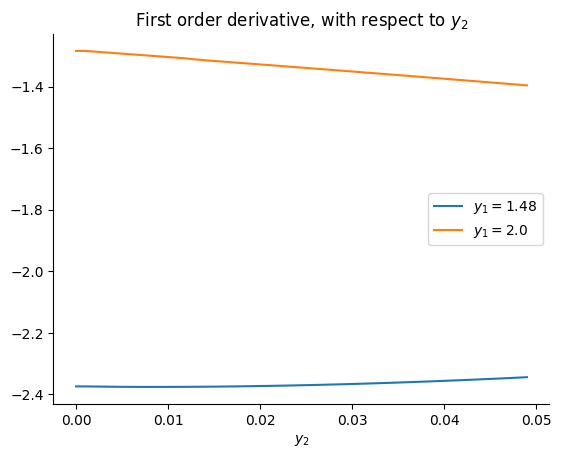

In [17]:
plt.title("First order derivative, with respect to $y_2$")
plt.plot(y2_grid, v0_dy2[37], label=r"$y_1 = {}$".format(y1_grid_cap[37]))
plt.plot(y2_grid, v0_dy2[-4], label=r"$y_1 = {}$".format(y1_grid_cap[-4]))
plt.xlabel(r"$y_2$")
plt.legend()
# plt.savefig("dv_dy2_y2")
plt.show()

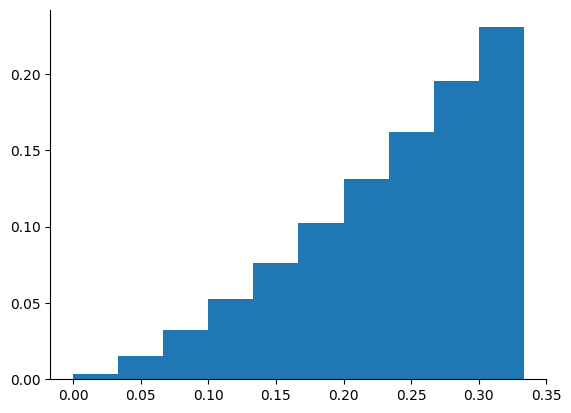

In [18]:
g_i = g_m[:, -1, 2]
plt.hist(γ3_list, weights= g_i/ np.sum(g_i, axis=0))
plt.show()

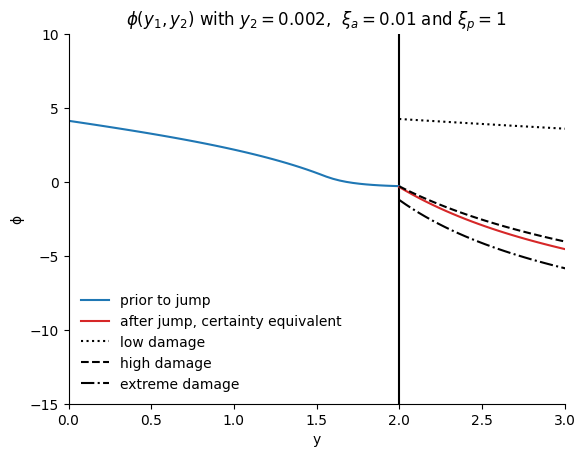

In [19]:
#
plt.plot(y1_grid[:loc_2 + 1],
         phi_mat[:loc_2 + 1, 2],
         color="tab:blue",
         label="prior to jump")
plt.plot(y1_grid[loc_2:],
         ϕ_equiv[loc_2:][:, 2],
         color="tab:red",
         label="after jump, certainty equivalent")
plt.plot(y1_grid[loc_2:],
         ϕ_list[0][loc_2:, 2],
         color="black",
         linestyle=":",
         label="low damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[10][loc_2:, 2],
         color="black",
         linestyle="--",
         label="high damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[-1][loc_2:, 2],
         color="black",
         linestyle="-.",
         label="extreme damage")

plt.legend(frameon=False)
plt.title("$ϕ(y_1, y_2)$ with $y_2 = 0.002$,  $ξ_a = 0.01$ and $ξ_p = 1$")
plt.vlines(2, ymax=10, ymin=-15, color="black")
plt.xlim(0, 3)
plt.ylim(-15, 10)
plt.xlabel("y")
plt.ylabel("ϕ")
# plt.savefig("./paper_plots/2_state_value_function.png", dpi=400, facecolor="w", edgecolor="w", bbox_inches="tight")
plt.show()

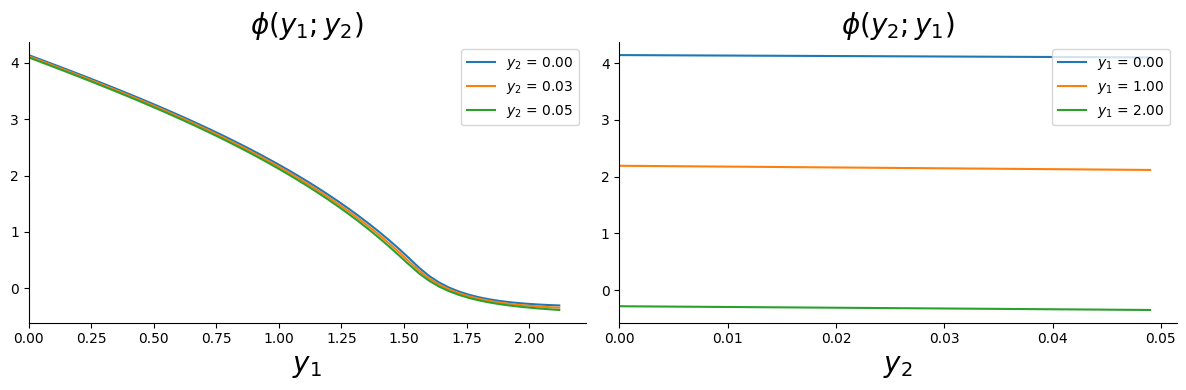

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], v0[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], v0[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], v0[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$ϕ(y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.legend()
# ax1.tick_params(labelsize=20)
ax1.set_xlim(0)
# ax1.set_ylim(-0.18, 0.05)
ax2.plot(y2_mat[0], v0[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1 / 4)], v0[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1 / 2)], v0[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
# ax2.plot(y2_mat[-1], v0[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$ϕ(y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.legend()
# ax2.set_ylim(-0.18, 0.05)
fig.tight_layout()
# plt.savefig("ϕ.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

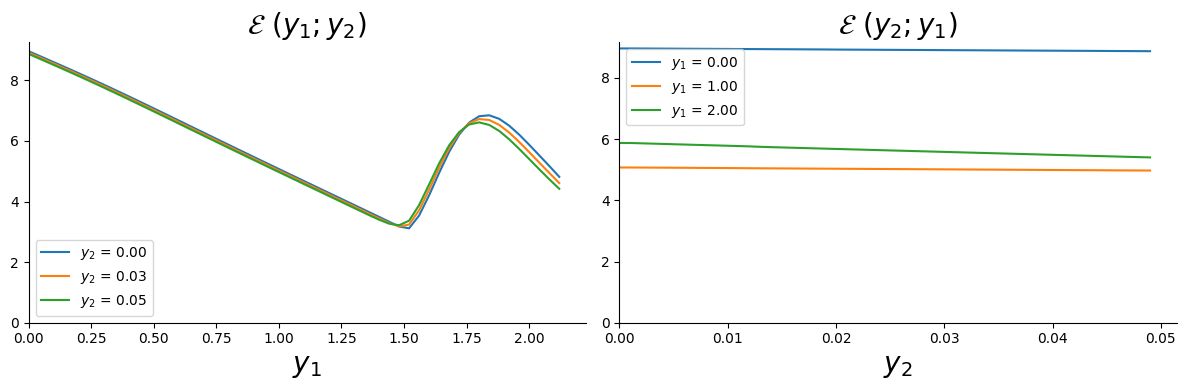

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], ems[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], ems[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}\ (y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(y2_mat[0], ems[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1/4)], ems[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1/2)], ems[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
ax2.set_title('$\mathcal{E}\ ( y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
ax2.legend()
# ax2.set_ylim(0,12)
fig.tight_layout()
# plt.savefig("E.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

In [22]:
from scipy import interpolate
def simualte_ems(y1_grid, y2_grid, ems, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
    Y2t = np.zeros(periods)
    ems_t = np.zeros(periods)
    f = interpolate.interp2d(y2_grid, y1_grid, ems, )
#     f_π = interpolate.interp2d(y2_grid, y1_grid, πa, )
    y1 = θ*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        ems_point = f(y2, y1)
#         π_list = f_π(y2, y1)
        ems_t[t] = ems_point[0]
        Y1t[t] = y1
        Y2t[t] = y2
        y1 += y2*dt
        y2 += ( - λ*y2 + λ*θ*ems_point)*dt
    return Y1t, Y2t, ems_t

In [23]:
def simulation(y1_grid, y2_grid, e_grid, λ, θ=1.86/1000., y1_0=.5394, y2_0=1.86/1000, T=100):
    e_fun = interpolate.interp2d(y1_grid, y2_grid, e_grid.T)
    Et = np.zeros(T+1)
    y1t = np.zeros(T+1)
    y2t = np.zeros(T+1)
    for i in range(T+1):
#         y2_0 = max(y2_0, 0)
#         y2_0 = min(y2_0, 0.05)
        Et[i] = e_fun(y1_0, y2_0)
        y1t[i] = y1_0
        y2t[i] = y2_0
        y2_0 = np.exp(-λ)*y2_0 + (1 - np.exp(-λ))*θ*Et[i] 
#         y2_0 = max(y2_0, 0)
        y1_0 = y1_0 + y2_0
    return Et, y1t, y2t

In [24]:
def simulation_1d(y_grid, e_grid, θ=1.86/1000., y_0=1.1, T=100):
    e_fun = interpolate.interp1d(y_grid, e_grid)
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = e_fun(y_0)
        yt[i] = y_0
        y_0 = y_0 + θ*Et[i] 
    return Et, yt

In [25]:
ems_1state = np.load("ems_1state.npy")
# ems_2state = np.load("ems_2state.npy")

In [26]:
i = 0
et1, yt1 = simulation_1d(np.arange(0, 5 + 0.01,  0.01), ems_1state[0], θ=np.mean(θ_list), y_0=2)
et2, y1t2, y2t2 = simulation(y1_grid, y2_grid, ems_list[0], λ, θ=np.mean(θ), y1_0=2)

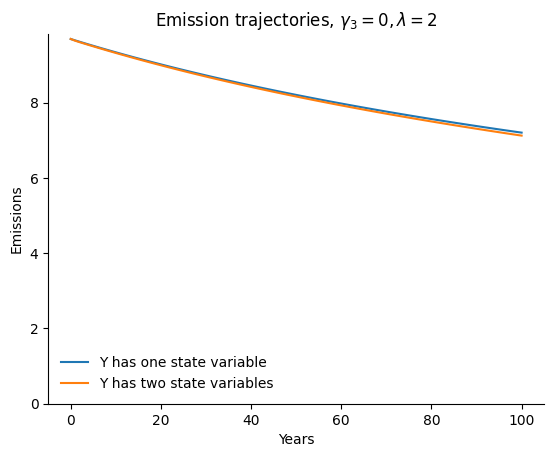

In [27]:
plt.title(f"Emission trajectories, $γ_3 = 0, λ = {λ}$")
plt.plot(et1, label="Y has one state variable")
plt.plot(et2, label="Y has two state variables")
plt.legend(frameon=False, loc=3)
plt.ylim(0)
plt.ylabel("Emissions")
plt.xlabel("Years")
# plt.savefig("ems_1_2_5")
plt.show()

In [28]:
et_prejump, y1t_prejump, y2t_prejump = simulation(y1_grid_cap,
                                                  y2_grid,
                                                  ems,
                                                  λ,
                                                  θ=np.mean(θ_list),
                                                  y1_0 = 1.1,
                                                  y2_0=np.mean(θ_list),
                                                  T=110
                                                 )

In [29]:
simul = {
    "et": et_prejump,
    "y1t": y1t_prejump,
    "y2t": y2t_prejump,
}

pickle.dump(simul, open("simul_2", "wb"))

In [30]:
y1t_prejump

array([1.1       , 1.10778121, 1.11629457, 1.1248504 , 1.13335749,
       1.14180415, 1.15018921, 1.15851293, 1.16677572, 1.17497808,
       1.18312047, 1.19120332, 1.19922708, 1.20719216, 1.21509891,
       1.22294774, 1.23073909, 1.23847336, 1.246151  , 1.2537724 ,
       1.26133799, 1.26884818, 1.27630338, 1.28370398, 1.29105041,
       1.29834305, 1.3055823 , 1.31276855, 1.31990218, 1.32698357,
       1.33401298, 1.34099078, 1.34791735, 1.35479306, 1.36161829,
       1.3683934 , 1.37511876, 1.38179471, 1.38842162, 1.39499987,
       1.4015298 , 1.4080118 , 1.41444634, 1.42083377, 1.42717443,
       1.43346866, 1.43971678, 1.44591913, 1.45207774, 1.45819317,
       1.46426574, 1.4702957 , 1.47628332, 1.48222885, 1.48814295,
       1.49404436, 1.49993561, 1.50581705, 1.51168869, 1.51755054,
       1.52340258, 1.52930873, 1.53532512, 1.54146188, 1.54772275,
       1.55411052, 1.56062791, 1.56728374, 1.57413985, 1.58121078,
       1.58850457, 1.59602849, 1.60378971, 1.61180528, 1.62009

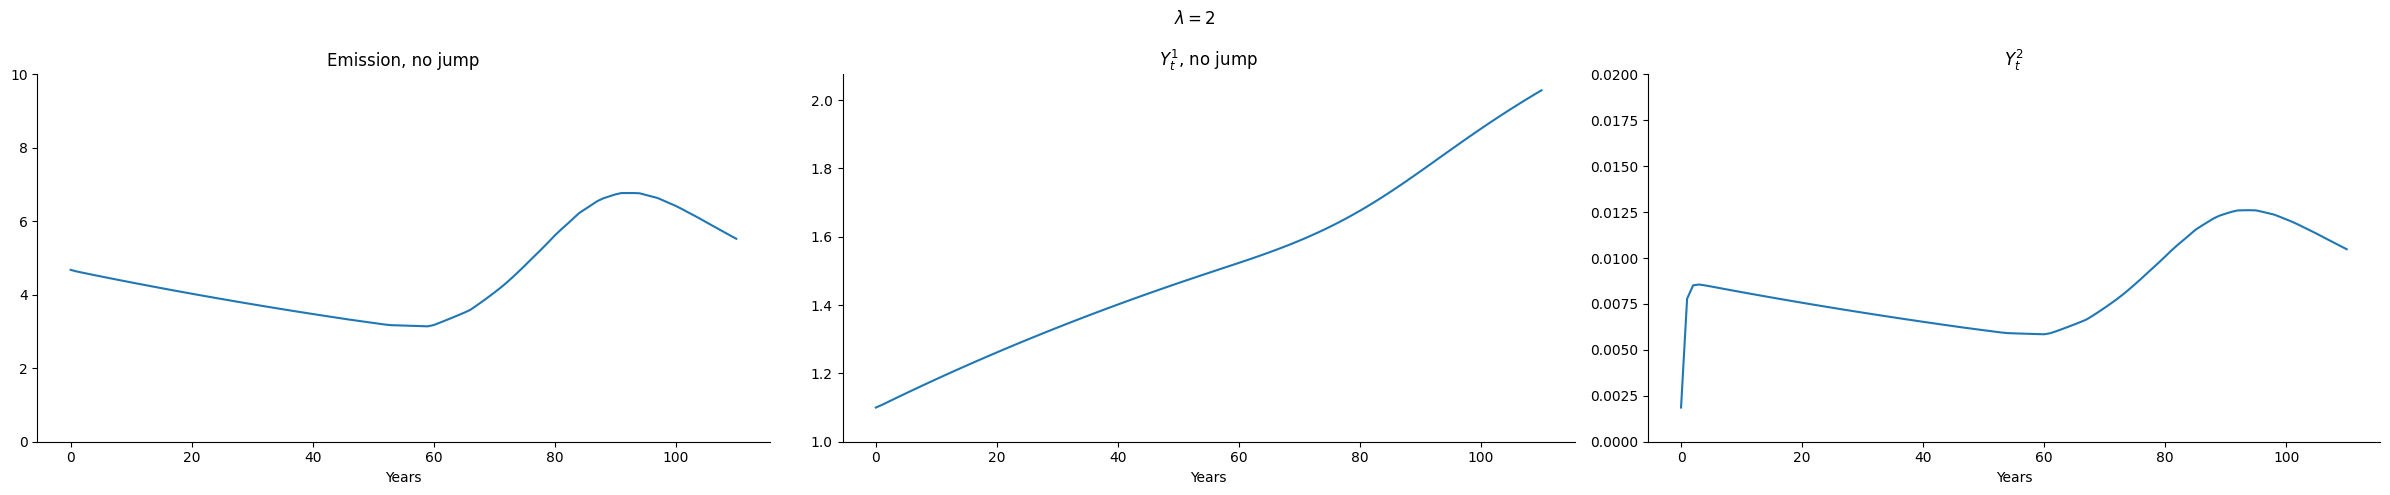

In [48]:
fig = plt.figure(figsize=(24, 5))
fig.suptitle(f"$\lambda = {λ}$")
plt.subplot(131)
plt.title("Emission, no jump")
plt.plot(et_prejump)
plt.ylim(0,10)
plt.xlabel("Years")
plt.subplot(132)
plt.xlabel("Years")
plt.title(r"$Y_t^1$, no jump")
plt.plot(y1t_prejump)
plt.ylim(1)
plt.subplot(133)
plt.title(r"$Y_t^2$")
plt.plot(y2t_prejump)
plt.ylim(0, 0.02)
plt.xlabel("Years")
plt.tight_layout()
# plt.savefig(f"e_y1_y2_{λ}")
plt.show()

In [41]:
y2_grid

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
       0.036, 0.037, 0.038, 0.039, 0.04 , 0.041, 0.042, 0.043, 0.044,
       0.045, 0.046, 0.047, 0.048, 0.049])

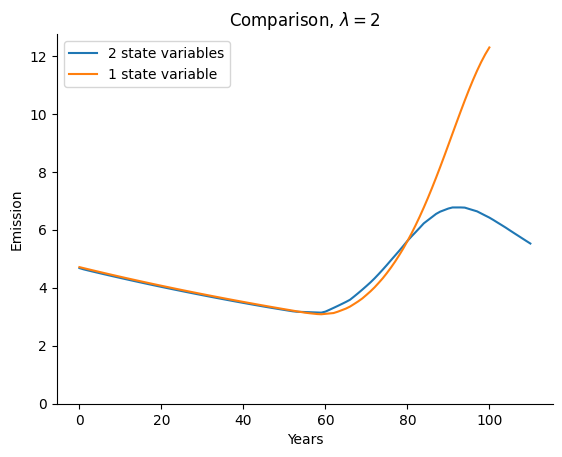

In [49]:
et_1state = np.load("et_1state.npy")
plt.plot(et_prejump, label="2 state variables")
plt.plot(et_1state, label="1 state variable")
plt.ylim(0)
plt.legend()
plt.xlabel("Years")
plt.ylabel("Emission")
plt.title(f'Comparison, $\lambda = {λ}$')
# plt.savefig(f"emissions_2_{λ}")
plt.show()

In [50]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [51]:
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0095
κ = 6.667
k0 = 85/α

In [54]:
Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0, T=111)
MC = δ*(1-η)/((α - invkap)*np.exp(Kt))
scc = η*(α - invkap)*np.exp(Kt)/(1-η)/et_prejump*1000

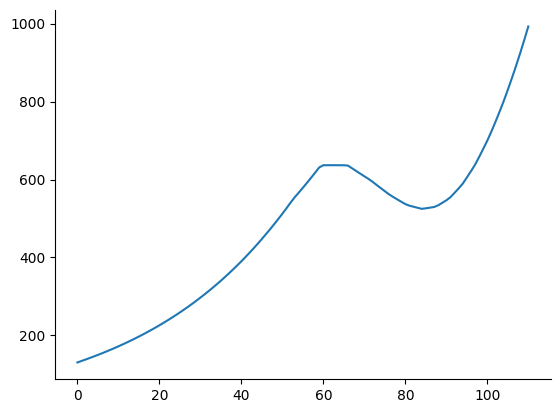

In [55]:
plt.plot(scc)
plt.show()

In [33]:
np.save(f"scct_{λ}", scc)